# Model Explainability with SHAP

This notebook analyzes model interpretability using SHAP.
y
- Sample for efficiency
- Use model-specific explainer

In [1]:
import joblib
import pandas as pd

pipeline = joblib.load("../models/churn_pipeline.pkl")

preprocessor = pipeline.named_steps["preprocess"]
model = pipeline.named_steps["model"]

In [2]:
# Load Data
df = pd.read_csv("../data/raw/Telco-Customer-Churn.csv")

# Replace blank strings with NaN
df = df.replace(r'^\s*$', float('nan'), regex=True)

# The known culprit in Telco dataset is TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop or fill NaN
df = df.dropna()  # or df.fillna(0)

X_raw = df.drop(columns=["Churn"])
y = df["Churn"]

In [3]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_raw,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [4]:
# Preprocess raw X_test (not already-transformed data)
X_test_processed = preprocessor.transform(X_test)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

In [5]:
import scipy.sparse

# Check if sparse, convert only if needed
if scipy.sparse.issparse(X_test_processed):
    X_test_processed = X_test_processed.toarray()

# Sample for SHAP
X_sample = X_test_processed[:500]

# Create DataFrame with feature names
feature_names = preprocessor.get_feature_names_out()
X_sample_df = pd.DataFrame(X_sample, columns=feature_names)

In [6]:
# SHAP Explainer
import shap

if hasattr(model, "feature_importances_"):
    # XGBoost - use TreeExplainer with DataFrame for proper feature names
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_sample_df)
else:
    # Logistic Regression - use LinearExplainer
    explainer = shap.LinearExplainer(model, X_sample_df)
    shap_values = explainer(X_sample_df)

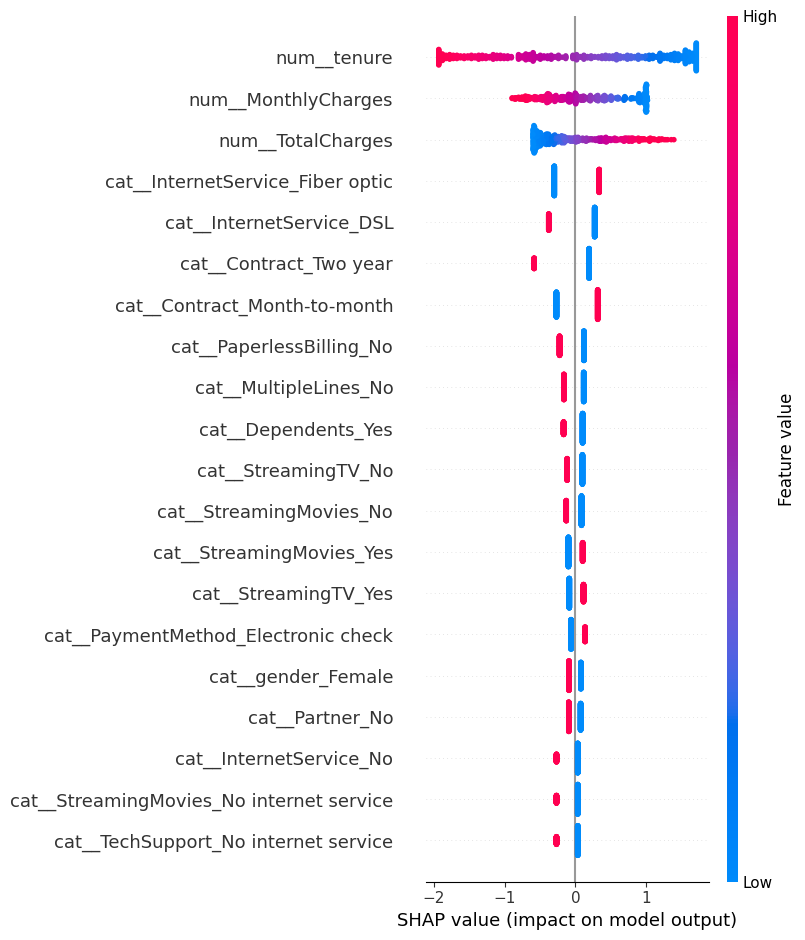

In [7]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_sample_df)

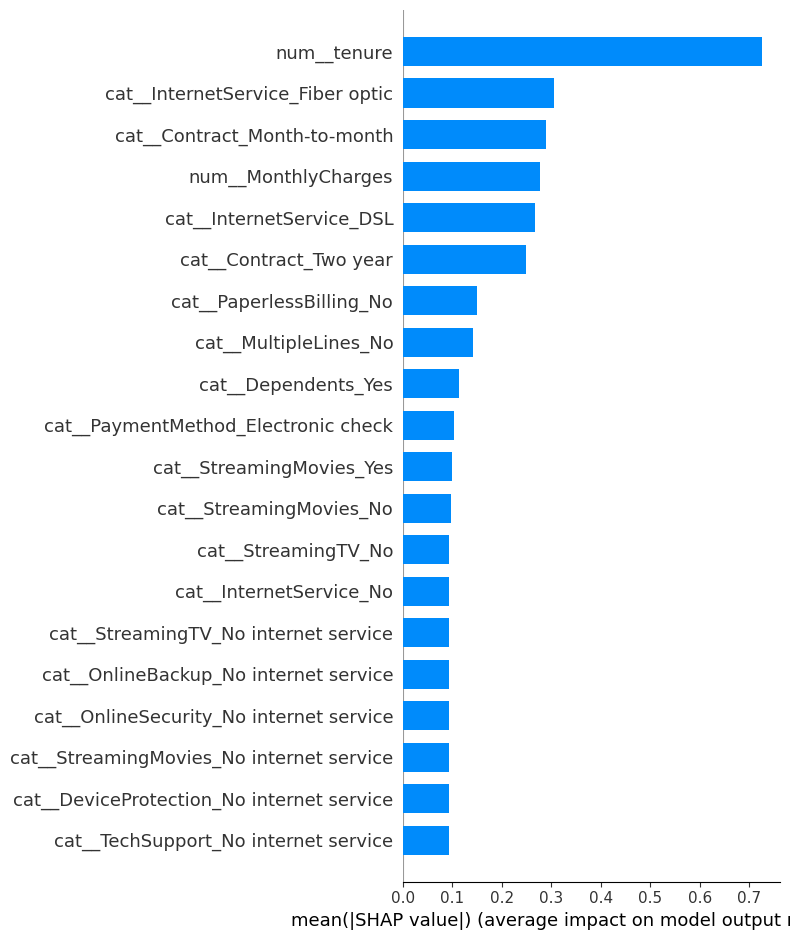

In [ ]:
# SHAP Bar Plot - Mean feature importance
shap.summary_plot(shap_values, X_sample_df, plot_type="bar")

## Interpretation

**Top Churn Drivers:**
- **Tenure** — the strongest predictor. Newer customers (low tenure) churn significantly more. Strategy: focus retention efforts in the first 3–6 months with onboarding support and early loyalty rewards.
- **Fiber optic internet** — fiber optic customers show higher churn risk despite it being a premium service, suggesting pricing or service quality issues. Strategy: investigate satisfaction among fiber optic users.
- **Month-to-month contracts** — customers on short-term contracts have significantly higher churn risk. Strategy: offer discounts to switch to annual or two-year plans.
- **High monthly charges** — customers paying more are more likely to churn. Strategy: introduce loyalty discounts for high-value customers.
- **No tech support / online security** — lack of added services correlates with churn. Strategy: bundle these services or offer free trials.

**Feature Impact Direction (from SHAP beeswarm plot):**
- Red points (high feature value) pushing right = increases churn probability
- Blue points (low feature value) pushing left = decreases churn probability
- Two-year contracts (blue) push left, confirming longer contracts strongly reduce churn